# The Gaussian copula and the meta-Gaussian distribution

In [1]:
%matplotlib inline
import elfi
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from elfi.examples import copula as copula_example_model
import elfi.methods.copula as cop

Due to Sklar's theorem the cumulative distribution function $F$ of a $p$-dimensional random variable $X$ can be expressed in terms of its marginal distribution functions $F_i$ and a copula $C$ as $$F(x_i, \dots, x_p) = C(F_i(x_1), \dots, F_p(x_p)) \, .$$ If the random variable $X$ also has a density function $f$, it further holds that
$$f(x) = c(F_i(x_1), \dots, F_p(x_p)) \prod_{i=1}^p f_i(x_i) \, ,$$ where $f_i$ are the marginal densities and $c = \frac{\partial^p C}{\partial F_1, \dots, \partial F_p}$ is the density of the copula. Notably, a multivariate Gaussian distribution can be written in this form
$$h(x) = \underbrace{\frac{1}{|R|^{\frac12}} \exp \left\{ -\frac12 u^T (R^{-1} - I) u \right\}}_{c_{G}(H_i(x_1), \dots, H_p(x_p))} \prod_{i=1}^p \underbrace{\frac{1}{\sigma_i}\phi(u_i)}_{h_i(x_i)}\, ,$$
where $u_i = \Phi^{-1}(F_i(x_i))$, $\phi$ is the standard normal density, $H_i$ and $h_i$ are the marginal CDFs and densities respectively, and $R$ is a correlation matrix.
Here the term $c_G$ is the density of the Gaussian copula. The meta-Gaussian distribution is obtained by substituting the normal distributions $h_i$ with arbitrary marginal densities.

As can be seen from the density function $h$, the meta-Gaussian distribution has the useful propery that the joint distribution is fully specified by the marginal distributions and the pairwise correlations between the different components. In large sample settings the posterior distribution of an ABC model is approximately normal. [*Li at al 2017*](https://doi.org/10.1016/j.csda.2016.07.005) *[1]* use this fact to justify using a meta-Gaussian approximation of the posterior. This enables us to break down the inference of high dimensional ABC models into multiple easier subproblems of estimating of 1- and 2-dimensional distributions.

A meta-Gaussian distribution can be constructed in ELFI by specifying the marginal distributions $h_i$ and the correlation matrix $R$. The marginal distributions can be any objects which implement the `cdf` and `ppf` methods, for example distributions from scipy. Here we define a meta-Gaussian distribution with beta and gamma distributed marginals with a correlation of 0.9.

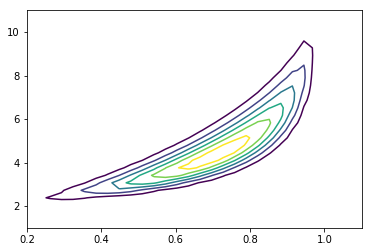

In [2]:
from elfi.utils import tabulate

rho = 0.9
corr = np.array([[1, rho],
                 [rho, 1]])
marginals = [ss.beta(5, 2),
             ss.gamma(3, 2)]

mg = cop.MetaGaussian(corr=corr, marginals=marginals)

t1 = np.linspace(0.2, 1.1, 30)
t2 = np.linspace(1, 11, 30)
grid, vals = tabulate(mg.pdf, t1, t2)
plt.contour(*grid, vals);

The marginal distributions can also be estimated from data using the `EmpiricalDensity` class. It estimates the density function using a Gaussian kernel density estimate and the cumulative distribution function using linear interpolation of the empirical CDF.

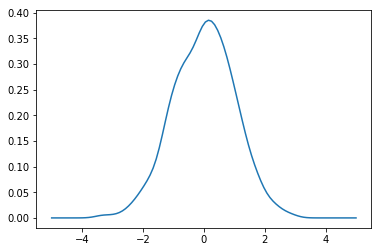

In [3]:
from elfi.methods.empirical_density import EmpiricalDensity
density_estimate = EmpiricalDensity(np.random.randn(1000))

t = np.linspace(-5, 5, 100)
plt.plot(t, density_estimate.pdf(t));

# Copula ABC

[*Li at al 2016*](https://doi.org/10.1016/j.csda.2016.07.005) *[1]* exploits the structure of the meta-Gaussian distribution to scale ABC to higher dimensional models. We assume that the summary statistic can be factorized into subsets that are informative for each component of the parameter vector of interest.

The principal difficulty of using Copula ABC in ELFI is the construction of the submodels needed for the approximation of the parameters of the meta-Gaussian distribution. The main idea is to produce an inference model that has discrepancy nodes corresponding to each informative subset of the summary statistic. Providing a general interface for the estimation of meta-Gaussian distributions for arbitrary ELFI models is very difficult. Instead of trying to achieve that, ELFI provides several utilities for constructing suitable inference models.

These utilities assume that there is a single summary statistic the components of which form the informative subsets for the components of the parameter. We also assume that there is only a single multivariate prior distribution. In addition, we assume that the bivariate summary statistics are the unions of the univariate ones. In other cases the inference model will have to be constructed by the user.

## Constructing the inference model

We will look at an example taken from [*Li at al 2016*](https://doi.org/10.1016/j.csda.2016.07.005) *[1]* to illustrate these tools.
Assume that the data $y$ is generated from a multivariate Gaussian $y \sim N_p(\mu, I)$, $p \geq 2$. We use a "twisted" Gaussian distribution as our prior for $\mu$, which is obtained by transforming the Gaussian distribution $N(0, \Sigma)$, where $\Sigma = \text{diag}([100, 1, 1, \dots, 1])$, by the function $g_b(x) = (x_1, x_2 + b x_1^2 - 100 b, x_3, \dots, x_p$). We use $b=0.1$ to get a strong correlation between the first two components, $y_{obs} = [10, 0, \dots, 0]$ as the observed data, and the identity function as the summary statistic $s = S(y) = y$.

Exploting our knowledge of the model, we use the summary statistic informative about $\mu_i$ to be $s_i$ with the expection of the second component, which we set to $s_{(2)} = (s_1, s_2)$. For the bivariate marginals, we use the unions of the previous summary statistics i.e $s_{(2, 3)} = (s_1, s_2, s_3)$.

This model is implemented in the file `examples/copula.py`

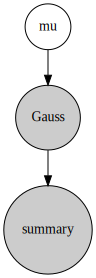

In [4]:
import elfi.examples.copula as copula_example

p = 3

m = copula_example.get_model(p)
elfi.draw(m)

The informative indices of the summary statistic are defined in a dictionary where each index of the parameter $\theta$ corresponds to a set of summary statistic indices that are informative for that particular index.

In [5]:
informative_indices = {i: set([i]) for i in range(p)}
informative_indices[1] = {0, 1}
informative_indices

{0: {0}, 1: {0, 1}, 2: {2}}

The function `complete_informative_indices` completes the definition of the informative indices by adding all the pairwise unions of the univariate summary statistics.

In [6]:
full_indices = cop.complete_informative_indices(informative_indices); full_indices

{0: {0}, 1: {0, 1}, 2: {2}, (0, 1): {0, 1}, (0, 2): {0, 2}, (1, 2): {0, 1, 2}}

Next, we need to add the summary statistic and discrepancy nodes corresponding to the subsets we defined. The `make_distances` function adds summary and distance nodes corresponding to the specified indices. By default the ELFI model is copied instead of modifying it in place. This behavious can be changed with the `inplace` keyword.

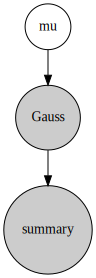

In [7]:
summary = m['summary']
distance_nodes = cop.make_distances(full_indices, summary)

# The model is not modified in place by default
elfi.draw(m)

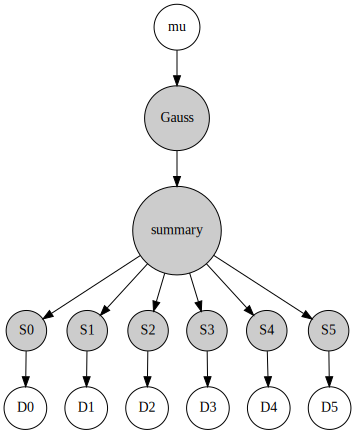

In [8]:
# Here is the modified model
elfi.draw(distance_nodes[0].model)

## Sampling and estimating parameters

Finally, we must specify which ABC method to use for each of the submodels. The `make_samplers` function will construct a dictionary of sampling algorithms for each of the marginal distributions. The `sampler_factory` argument needs to be given a function which, given a discrepancy node, will produce an ABC method for sampling the corresponding subtree.

In [9]:
def Rejection(**kwargs):
    def wrapper(dist):
        return elfi.Rejection(dist, **kwargs)
    
    return wrapper

samplers = cop.make_samplers(distance_nodes, Rejection(batch_size=100)); samplers

{0: <elfi.methods.parameter_inference.Rejection at 0x7f7c34dbcb70>,
 1: <elfi.methods.parameter_inference.Rejection at 0x7f7c34dbc7f0>,
 2: <elfi.methods.parameter_inference.Rejection at 0x7f7c34dbc828>,
 (0, 1): <elfi.methods.parameter_inference.Rejection at 0x7f7c318d5e48>,
 (0, 2): <elfi.methods.parameter_inference.Rejection at 0x7f7c318d5d30>,
 (1, 2): <elfi.methods.parameter_inference.Rejection at 0x7f7c3188a978>}

The `get_samples` function provides a convenient way to obtain samples from the marginal distributions.

In [10]:
# sample from the first component
sample0 = cop.get_samples(marginal=0, samplers=samplers, n_samples=10, parameter='mu', quantile=0.01)

# sample from the bivariate marginal of the first and second component
sample01 = cop.get_samples(marginal=(0, 1), samplers=samplers, n_samples=10, parameter='mu', quantile=0.1)
sample01

array([[ 10.12458094,  -0.34361509],
       [ 10.32973766,  -0.11151202],
       [ 10.4543039 ,   0.88037059],
       [  9.7001714 ,  -0.72125532],
       [  8.72422637,  -0.61956627],
       [  8.5309231 ,  -1.66679084],
       [  9.45367479,  -2.22192606],
       [  8.15725267,  -3.31162316],
       [  8.07435954,  -2.91001204],
       [  7.45411963,  -3.08317957]])

The entries in the correlation matrix $R$ can be estimated using bivariate samples from $(\mu_i, \mu_j)$ as described in [*Li at al 2016*](https://doi.org/10.1016/j.csda.2016.07.005) *[1]*. This is done with the `estimate_correlation` function. There are no guarantees that the correlation matrix constructed from the pairwise correlations is positive deifinite. In such cases other estimations for the correlation matrix will have to be made.

In [11]:
cop.estimate_correlation(marginal=(0, 1), samplers=samplers, parameter='mu', n_samples=100, quantile=0.01)

0.7002648560729805

## Estimating the meta-Gaussian

The `copula_abc` function combines all the previous steps to produce a meta-Gaussian approximation of the posterior distribution. In this case we are only interested in the marginal distribution of the first two components so we only define a part of the informative indices. Note that the dimensionality of the model doesn't affect the estimation as the marginal is estimated in the same way in all cases.

In [12]:
informative_indices = {0: 0, 1: {0, 1}}
posterior = cop.copula_abc(informative_indices, summary=m['summary'],
                           parameter='mu',
                           sampler_factory=Rejection(batch_size=1000),
                           n_samples=10000, quantile=0.01)

Estimating correlations: 100%|██████████| 1/1 [02:04<00:00, 124.15s/it]


In [13]:
from elfi.visualization.visualization import compare, overlay
from elfi.utils import tabulate

analytic_posterior = copula_example.Posterior(p=2)

# Comparison to naive rejection sampling

A naive application of rejection sampling does not take the the struvture of the model into account and the performance depends heavily on the dimensionality of the model.

In [14]:
p = 100
m2 = copula_example_model.get_model(p)
d = elfi.Distance('euclidean', m2['Gauss'])
rej = elfi.Rejection(d)
res = rej.sample(n_samples=1000, quantile=0.01)

In [15]:
rejection_posterior = res.outputs['mu'][:, [0, 1]]
rp0 = rejection_posterior[:, 0]
rp1 = rejection_posterior[:, 1]
kde_rp0 = ss.gaussian_kde(rp0)
kde_rp1 = ss.gaussian_kde(rp1)

In [16]:
def mposterior(x, b=0.1):
    t1 = x[0]
    t2 = x[1]
    C = 1/(40*np.pi**2)
    return C*np.exp(-(-10 + t1)**2/2. - t1**2/200. - t2**2/2. - (-(b*(-100 + t1**2)) + t2)**2/2.)

In [17]:
def posterior_0(t1, b=0.1):
    """Un-normalized marginal"""
    return np.exp(-50 + 10*t1 - (101*t1**2)/200. - (b**2*(-100 + t1**2)**2)/4.)*np.sqrt(np.pi)

In [18]:
MAP = mposterior(np.array([10, 0]))

In [19]:
MAP

0.0015363601089363004

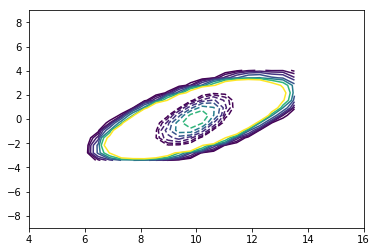

In [20]:
levels = np.logspace(np.log(0.0001), np.log(MAP), 8, base=np.e)

t1 = np.linspace(4, 16, 30)
t2 = np.linspace(-9, 9, 30)
overlay({posterior.pdf: {'levels': levels},
         mposterior: {'linestyles': 'dashed', 'levels': levels}}, t1, t2)

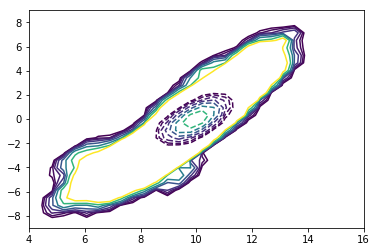

In [21]:
# t1 = np.linspace(6, 13, 30)
# t2 = np.linspace(-8, 8, 30)
kde = ss.gaussian_kde(np.transpose(rejection_posterior))
overlay({kde.pdf: {'levels': levels},
         mposterior: {'linestyles': 'dashed', 'levels': levels}}, t1, t2)

## Marginals

The Copula ABC (blue line) has better summary statistics for inferring the second component and produces a better result compared to the naive rejection sampling approach (orange dashed line).

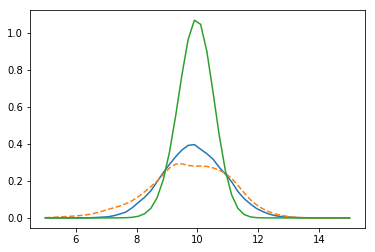

In [22]:
overlay({posterior.marginals[0].pdf: {}, kde_rp0.pdf: {'linestyle': 'dashed'},
         posterior_0:{}}, np.linspace(5, 15, 50))

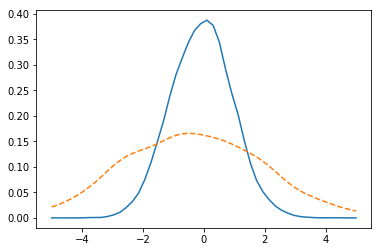

In [23]:
overlay({posterior.marginals[1].pdf: {}, kde_rp1.pdf: {'linestyle': 'dashed'}}, np.linspace(-5, 5, 50))

# Model validation

The Copula ABC method relies on the approximate normality of the posterior. [*Li at al 2017*](https://doi.org/10.1016/j.csda.2016.07.005) *[1]* suggest comparing the bivariate meta-Gaussian approximations to density estimates of corrected samples based on the informative summary statistics.

# References

- [1] J.Li, D.J.Nott, Y.Fan, S.A.Sisson; Extending approximate Bayesian computation methods to high dimensions via a Gaussian copula model. Computational Statistics & Data Analytics Volume 106, February 2017, Pages 77-89; doi: 10.1016/j.csda.2016.07.005